# Installing necessary packages & uploading Dataset

In [9]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [11]:
from google.colab import files
uploaded = files.upload()  # Upload 'jollof_wars_rice_sales_messy.csv'
sales_data = pd.read_csv(next(iter(uploaded)))

Saving jollof_wars_rice_sales_messy.csv to jollof_wars_rice_sales_messy (1).csv


#  2. DATA CLEANING & FEATURE ENGINEERING

In [12]:
# Step 1: Select only relevant columns.
sales_data = sales_data[[
    'Brand Name', 'Grain Type', 'Price per Bag (Naira)', 'City', 'Country',
    'Customer Rating', 'Number of Reviews', 'Month Sold', 'Units Sold'
]]

# Step 2: Rename columns for consistency
sales_data.columns = ['brand', 'grain_type', 'price', 'city', 'country',
                      'rating', 'reviews', 'month', 'units_sold']

# Step 3: Fix brand name typos
brand_fixes = {
    'Caprce': 'Caprice',
    'Uncl Sam': 'Uncle Sam',
    'Royal Stallon': 'Royal Stallion',
    'Mamma Gold': 'Mama Gold'
}
sales_data['brand'] = sales_data['brand'].replace(brand_fixes)

# Step 4: Standardize grain types and cities
sales_data['grain_type'] = sales_data['grain_type'].str.lower().str.replace(' ', '_').str.capitalize()
sales_data['city'] = sales_data['city'].str.title().replace({'Kumaci': 'Kumasi', 'Acccra': 'Accra'})

# Step 5: Clean and convert price column
sales_data['price'] = (
    sales_data['price']
    .astype(str)
    .str.replace('₦', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)

# Step 6: Impute missing prices with mean based on brand + city + grain
sales_data['price'] = sales_data.groupby(['brand', 'city', 'grain_type'])['price'].transform(
    lambda x: x.fillna(x.mean())
)

# Step 7: Create revenue column
sales_data['revenue'] = sales_data['price'] * sales_data['units_sold']

# Step 8: Create price tier column
def classify_price(price):
    if price < 15000:
        return 'Low'
    elif 15000 <= price < 23000:
        return 'Medium'
    else:
        return 'Premium'

sales_data['price_tier'] = sales_data['price'].apply(classify_price)

# Clean and order 'month' column
sales_data['month'] = sales_data['month'].str.strip().str.capitalize()
months_order = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']
sales_data['month'] = pd.Categorical(sales_data['month'], categories=months_order, ordered=True)

# Step 9: Rename columns for final export
sales_data.columns = [
    'brand_name', 'grain_type', 'price_per_bag', 'city', 'country',
    'customer_rating', 'review_count', 'month_sold', 'units_sold',
    'revenue', 'price_tier'
]

# Step 10: Export to CSV
sales_data.to_csv("jollof_wars_FULLY_CLEANED.csv", index=False)

# Step 11: Preview
print("SAMPLE CLEANED DATA:")
print(sales_data.sample(5).to_markdown())

print("\nCOLUMN CHECK:")
print(sales_data.columns)

print("\nNULL CHECK:")
print(sales_data.isnull().sum())


SAMPLE CLEANED DATA:
|     | brand_name   | grain_type   |   price_per_bag | city   | country   |   customer_rating |   review_count | month_sold   |   units_sold |     revenue | price_tier   |
|----:|:-------------|:-------------|----------------:|:-------|:----------|------------------:|---------------:|:-------------|-------------:|------------:|:-------------|
| 408 | Tommy Tasty  | Basmati      |        15292.6  | Abuja  | Nigeria   |                 3 |            274 | April        |          487 | 7.4475e+06  | Medium       |
| 219 | Caprice      | Basmati      |        18822.7  | Abuja  | Nigeria   |                 3 |            147 | November     |          592 | 1.1143e+07  | Medium       |
| 440 | Sunshine     | Local        |         9898.98 | Lagos  | Nigeria   |                 5 |             45 | September    |          709 | 7.01838e+06 | Low          |
| 130 | Tommy Tasty  | Long_grain   |        14773.2  | Abuja  | Nigeria   |                 1 |            120 | 

# Descriptive Statistics

In [13]:
print("\nBasic Stats:")
print(sales_data.describe(include='all'))

# Outlier detection: z-score method
z_scores = np.abs((sales_data['price_per_bag'] - sales_data['price_per_bag'].mean()) / sales_data['price_per_bag'].std())
outliers = sales_data[z_scores > 3]
print(f"\nDetected {len(outliers)} potential price outliers (Z-score > 3)")


Basic Stats:
       brand_name  grain_type  price_per_bag    city country  customer_rating  \
count         554         554     554.000000     554     554       554.000000   
unique          8           3            NaN       4       2              NaN   
top       Caprice  Long_grain            NaN  Kumasi   Ghana              NaN   
freq           84         191            NaN     146     290              NaN   
mean          NaN         NaN   16325.155446     NaN     NaN         2.949458   
std           NaN         NaN    4833.815879     NaN     NaN         1.418417   
min           NaN         NaN    8035.850000     NaN     NaN         1.000000   
25%           NaN         NaN   12425.010000     NaN     NaN         2.000000   
50%           NaN         NaN   16123.805000     NaN     NaN         3.000000   
75%           NaN         NaN   20492.310000     NaN     NaN         4.000000   
max           NaN         NaN   24967.080000     NaN     NaN         5.000000   

        revie

# Monthly Distribution
# How many sales occurred per month.

Analyze the Month Sold column to uncover sales distribution across months, spot any peaks/troughs, and assess if seasonality or timing may influence the launch strategy for RizoStar.



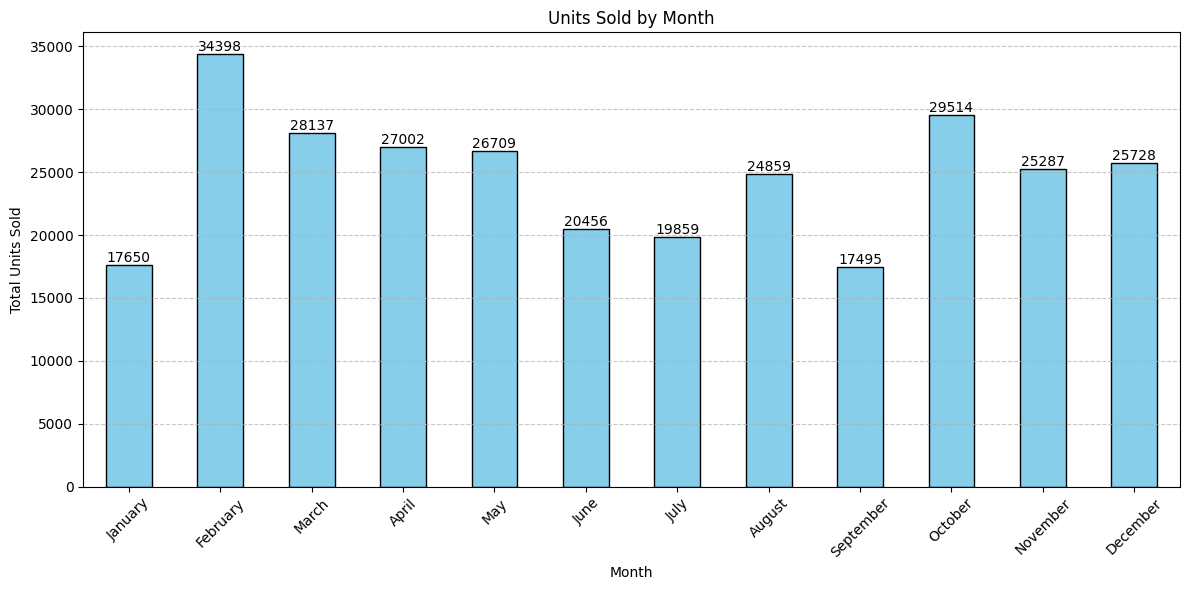

In [25]:
# Aggregate total units sold per month

monthly_units_sold = sales_data.groupby('month_sold', observed=True)['units_sold'].sum()
monthly_units_sold = monthly_units_sold.reindex(months_order)


plt.figure(figsize=(12, 6))
ax = monthly_units_sold.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Units Sold by Month')
plt.xlabel('Month')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add labels on top of bars (units sold)
for p in ax.patches:
    ax.annotate(str(int(p.get_height())),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.show()

# Grain-Type Satisfaction Aggregation


Customer Satisfaction by Grain Type:
|    | grain_type   |   customer_rating |   units_sold |
|---:|:-------------|------------------:|-------------:|
|  0 | Basmati      |           3.01579 |        98667 |
|  2 | Long_grain   |           2.99476 |       103745 |
|  1 | Local        |           2.82659 |        94682 |


<Figure size 1200x600 with 0 Axes>

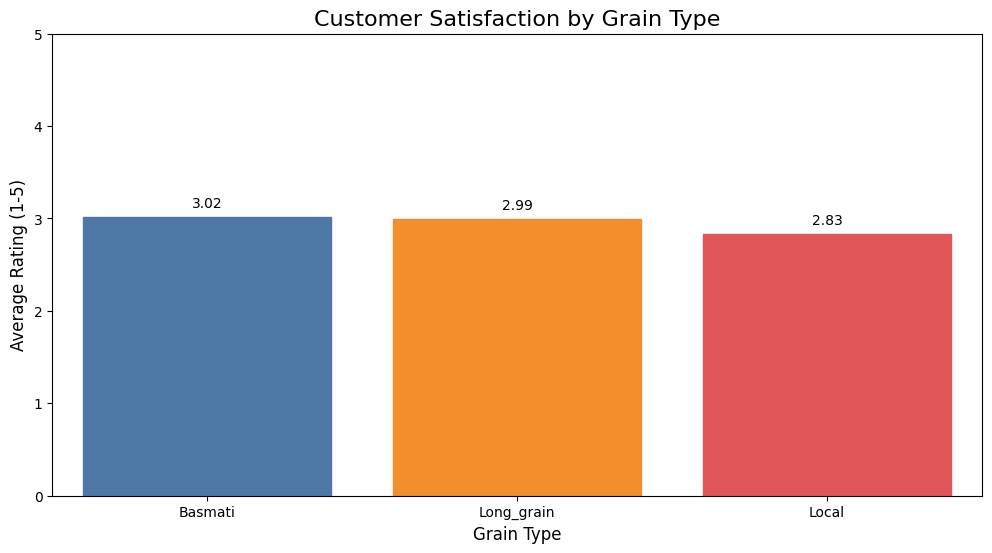

In [44]:
# Aggregate satisfaction by grain type
grain_satisfaction = sales_data.groupby('grain_type').agg({
    'customer_rating': 'mean',
    'units_sold': 'sum'
}).reset_index()

print("\nCustomer Satisfaction by Grain Type:")
print(grain_satisfaction.sort_values('customer_rating', ascending=False).to_markdown())

plt.figure(figsize=(12, 6))

colors = ['#4E79A7', '#F28E2B', '#E15759']

plt.figure(figsize=(12, 6))
grain_plot = sns.barplot(data=grain_satisfaction,
                        x='grain_type',
                        y='customer_rating',
                        order=['Basmati', 'Long_grain', 'Local'],
                        palette=None)

for patch, color in zip(grain_plot.patches, colors):
    patch.set_color(color)

plt.title('Customer Satisfaction by Grain Type', fontsize=16)
plt.xlabel('Grain Type', fontsize=12)
plt.ylabel('Average Rating (1-5)', fontsize=12)
plt.ylim(0, 5)

for p in grain_plot.patches:
    grain_plot.annotate(f"{p.get_height():.2f}",
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 10),
                       textcoords='offset points')

plt.savefig('grain_type_satisfaction.jpg', bbox_inches='tight', dpi=300)
plt.show()

# 3. EXPLORATORY ANALYSIS (WITH VISUALS)

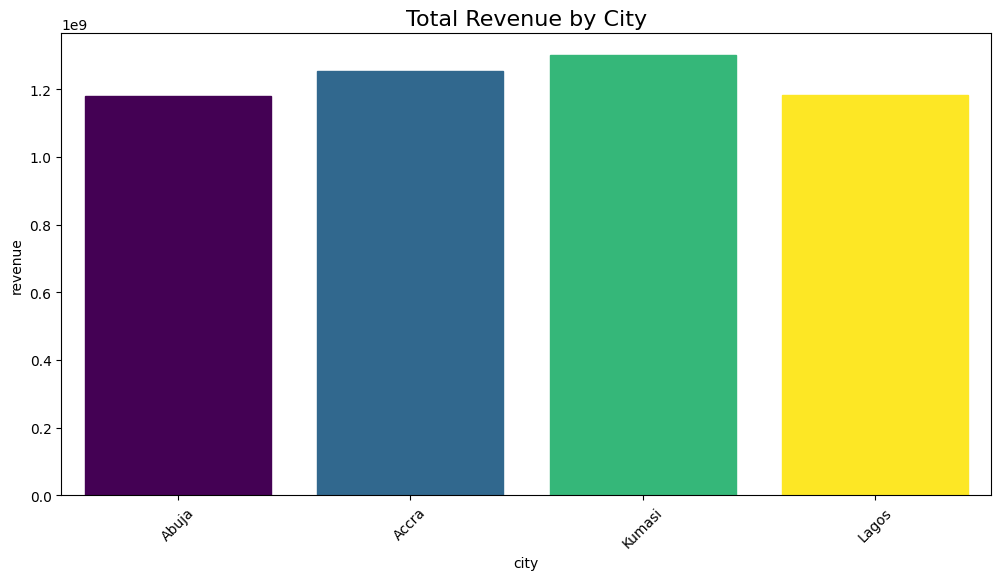

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(12, 6))

city_stats = sales_data.groupby('city').agg({
    'revenue': 'sum',
    'customer_rating': 'mean',
    'units_sold': 'sum'
})

# Generate colors from viridis colormap for each city
num_cities = len(city_stats)
colors = cm.viridis(np.linspace(0, 1, num_cities))

# Plot without palette, then set colors manually
barplot = sns.barplot(x=city_stats.index, y=city_stats['revenue'], palette=None)

# Apply colors manually
for patch, color in zip(barplot.patches, colors):
    patch.set_color(color)

plt.title('Total Revenue by City', fontsize=16)
plt.xticks(rotation=45)
plt.savefig('revenue_by_city.png', bbox_inches='tight')
plt.show()

# Price Tier Categorization

price_tier
Medium     316
Low        238
Premium      0
Name: count, dtype: int64


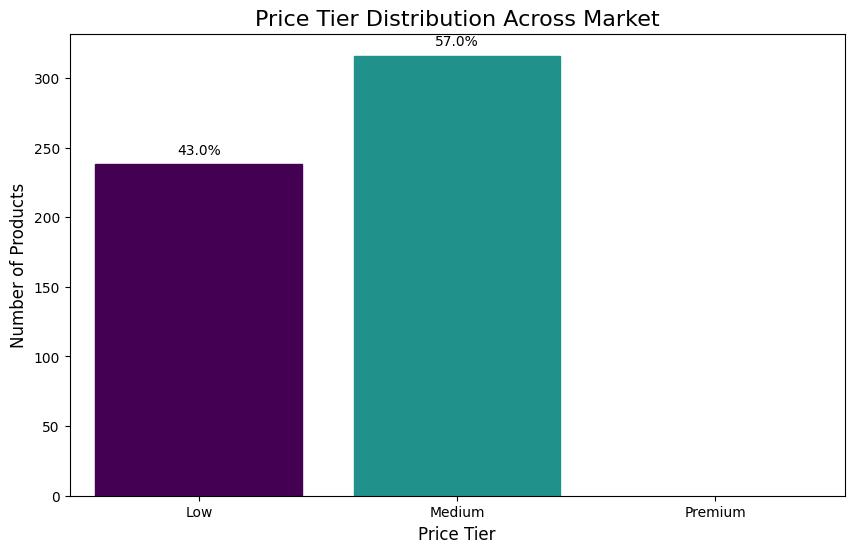

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np

# Categorize prices into tiers
price_bins = [0, 15000, 25000, float('inf')]
tier_labels = ['Low', 'Medium', 'Premium']
sales_data['price_tier'] = pd.cut(
    sales_data['price_per_bag'],
    bins=price_bins,
    labels=tier_labels
)

# Verify
print(sales_data['price_tier'].value_counts())

plt.figure(figsize=(10, 6))

# Plot without palette argument
price_tier_plot = sns.countplot(data=sales_data, x='price_tier', order=tier_labels)

# Create color map and assign colors manually
num_bars = len(tier_labels)
colors = cm.viridis(np.linspace(0, 1, num_bars))

for patch, color in zip(price_tier_plot.patches, colors):
    patch.set_color(color)

plt.title('Price Tier Distribution Across Market', fontsize=16)
plt.xlabel('Price Tier', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)

# Add percentage labels
total = len(sales_data)
for p in price_tier_plot.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    price_tier_plot.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points'
    )

plt.savefig('price_tier_distribution.jpg', bbox_inches='tight', dpi=300)
plt.show()

# Brand Dominance by City

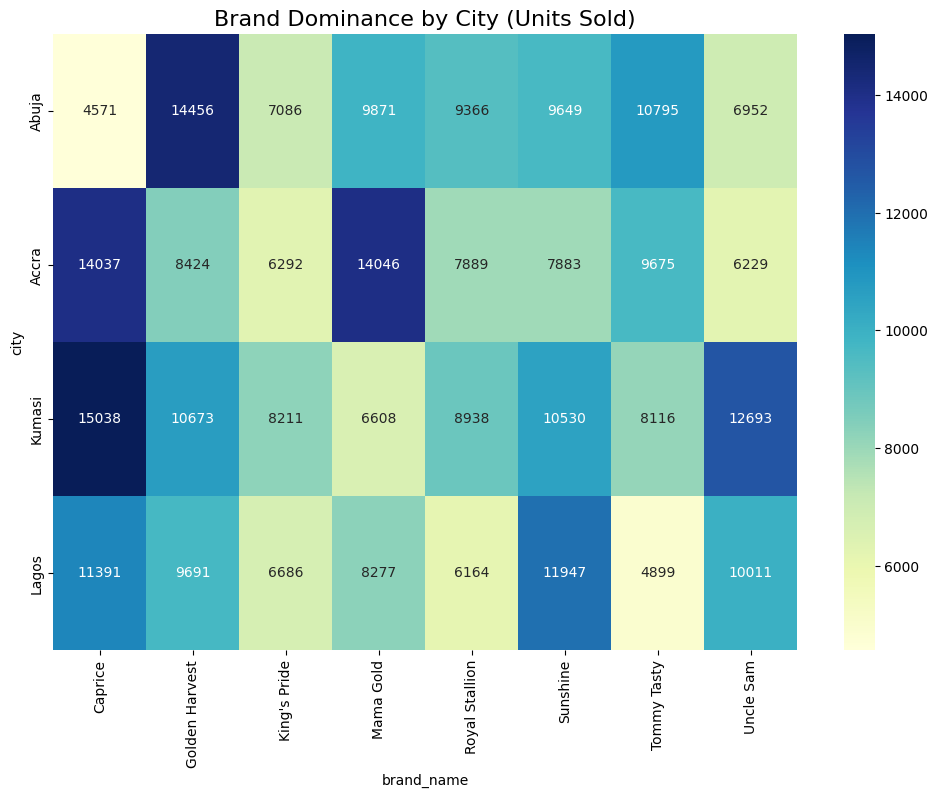

In [29]:
# Brand Monopoly Heatmap
brand_city_matrix = sales_data.groupby(['city', 'brand_name'])['units_sold'].sum().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(brand_city_matrix.fillna(0), cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('Brand Dominance by City (Units Sold)', fontsize=16)
plt.savefig('brand_monopoly_heatmap.png')
plt.show()

# Suspicious Trends Detection

In [30]:
# Suspicious Trends Detection
sales_data['suspicious'] = (sales_data['review_count'] < sales_data['review_count'].quantile(0.1)) & \
                           (sales_data['units_sold'] > sales_data['units_sold'].quantile(0.9))

suspicious_entries = sales_data[sales_data['suspicious']]

print("Suspicious Entries (Low Reviews + High Sales):")
print(suspicious_entries[['brand_name', 'city', 'price_per_bag', 'review_count', 'units_sold']].to_markdown())


Suspicious Entries (Low Reviews + High Sales):
|     | brand_name     | city   |   price_per_bag |   review_count |   units_sold |
|----:|:---------------|:-------|----------------:|---------------:|-------------:|
| 193 | Sunshine       | Lagos  |        19224.9  |              2 |          953 |
| 269 | Sunshine       | Abuja  |         9998.11 |              0 |          964 |
| 286 | Golden Harvest | Lagos  |        14497.7  |              3 |          966 |
| 306 | Uncle Sam      | Kumasi |        17989.2  |             26 |          993 |
| 514 | Caprice        | Lagos  |        16531.6  |             22 |          937 |


# Bar Chart — Suspicious Units Sold per Brand
# This chart shows which brands had suspiciously high sales with low reviews.

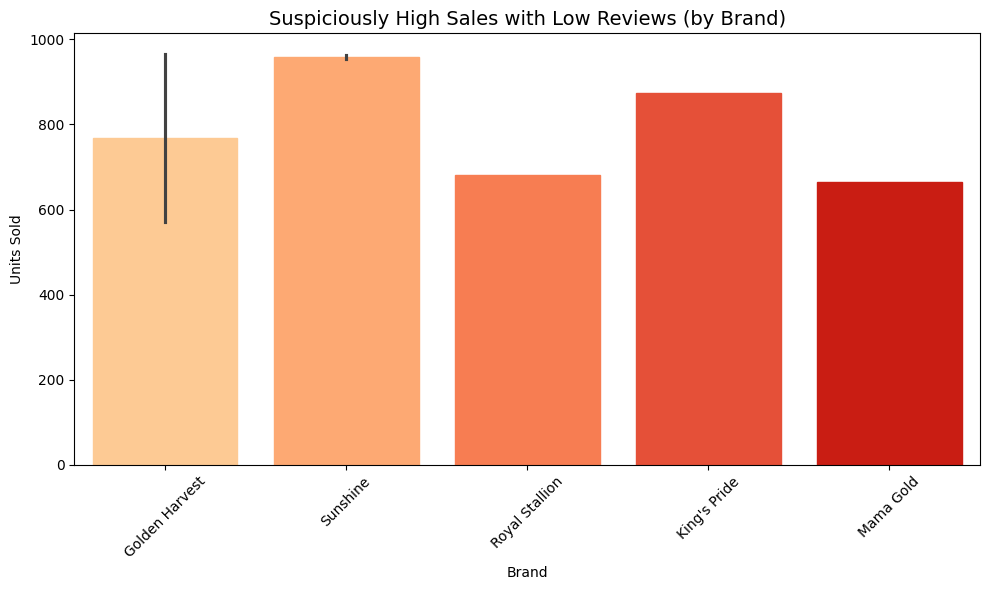

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(10, 6))

# Plot without palette argument to avoid warning
barplot = sns.barplot(
    data=suspicious_entries,
    x='brand_name',
    y='units_sold'
)

# Create a colormap and assign colors manually
num_bars = suspicious_entries['brand_name'].nunique()
colors = cm.OrRd(np.linspace(0.3, 0.8, num_bars))

for patch, color in zip(barplot.patches, colors):
    patch.set_color(color)

plt.title("Suspiciously High Sales with Low Reviews (by Brand)", fontsize=14)
plt.ylabel("Units Sold")
plt.xlabel("Brand")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("suspicious_sales_by_brand.png")
plt.show()

# General Relationship: Reviews vs Units Sold
# This explores whether there's any overall trend between customer reviews and
# units sold.

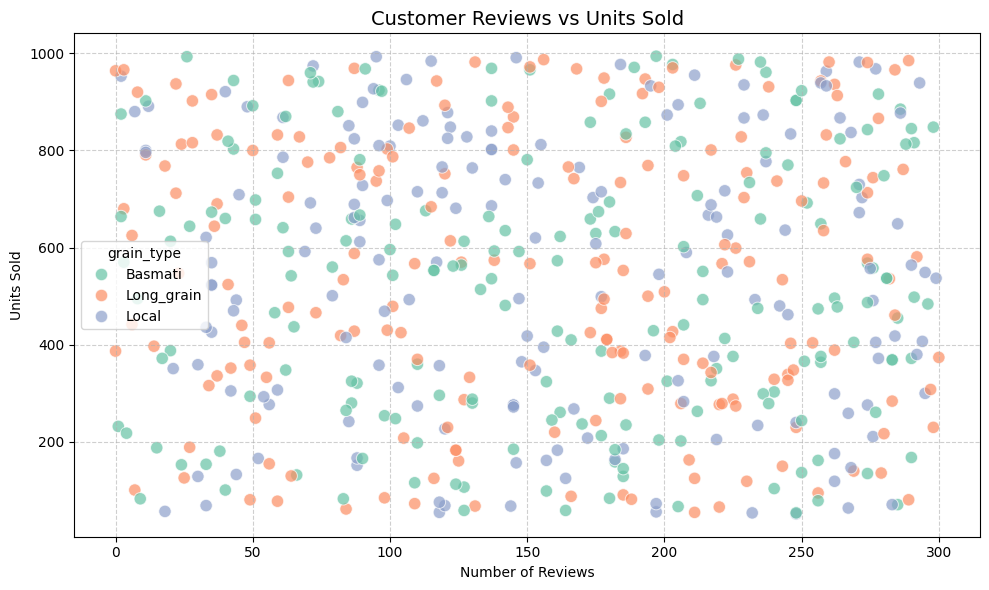

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sales_data,
    x='review_count',
    y='units_sold',
    hue='grain_type',  # or use 'brand_name'
    palette='Set2',
    s=80,
    alpha=0.7
)
plt.title("Customer Reviews vs Units Sold", fontsize=14)
plt.xlabel("Number of Reviews")
plt.ylabel("Units Sold")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("reviews_vs_sales_scatter.png")
plt.show()


# Suspicious Sales Pattern: High Sales, Few Reviews.
# This show only those rows with high units sold but very low review counts, possibly offline or manipulated data.

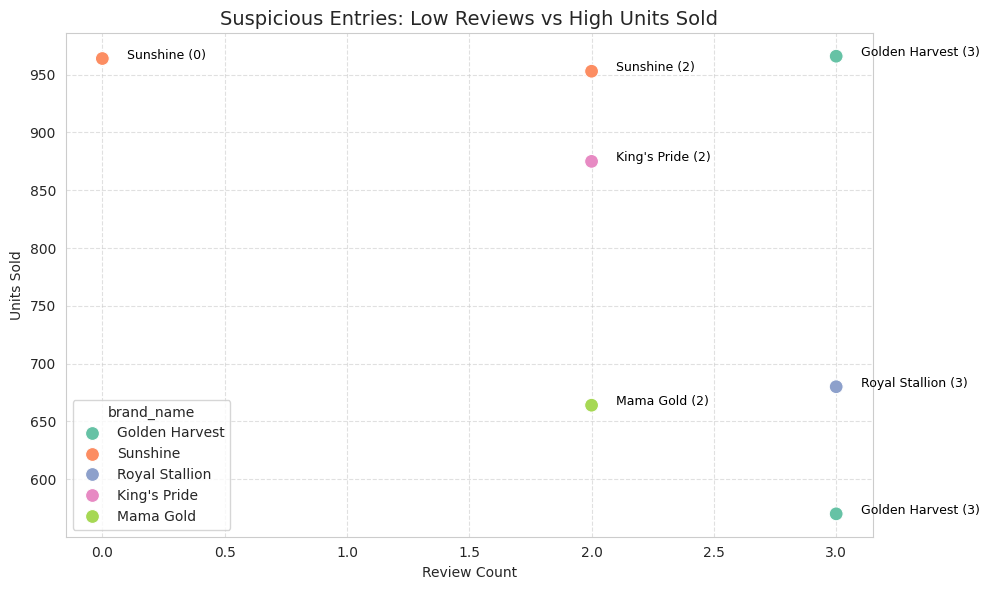

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your suspicious entries (already filtered)
suspicious_entries = sales_data[(sales_data['review_count'] <= 3) & (sales_data['units_sold'] > 500)]

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    data=suspicious_entries,
    x='review_count',
    y='units_sold',
    hue='brand_name',
    s=100,
    palette='Set2',
    legend='full'
)

# Annotate points with brand name and review count
for i in range(suspicious_entries.shape[0]):
    row = suspicious_entries.iloc[i]
    plt.text(
        row['review_count'] + 0.1,
        row['units_sold'],
        f"{row['brand_name']} ({row['review_count']})",
        fontsize=9,
        color='black'
    )

plt.title("Suspicious Entries: Low Reviews vs High Units Sold", fontsize=14)
plt.xlabel("Review Count")
plt.ylabel("Units Sold")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig("suspicious_scatter_annotated.png", dpi=300, transparent=True)
plt.show()

In [63]:
print(suspicious_entries[['brand_name', 'review_count', 'units_sold']])

         brand_name  review_count  units_sold
75   Golden Harvest             3         570
193        Sunshine             2         953
269        Sunshine             0         964
286  Golden Harvest             3         966
409  Royal Stallion             3         680
484    King's Pride             2         875
544       Mama Gold             2         664


# Weighted customer rating = rating * review count

In [58]:
# Weighted customer rating = rating * review count
sales_data['weighted_rating'] = sales_data['customer_rating'] * sales_data['review_count']

# Group by city and brand
weighted_city_rating = sales_data.groupby(['city', 'brand_name']).agg(
    total_weighted_rating=('weighted_rating', 'sum'),
    total_reviews=('review_count', 'sum')
).reset_index()

# Avoid division by zero
weighted_city_rating['weighted_avg_rating'] = weighted_city_rating.apply(
    lambda row: row['total_weighted_rating'] / row['total_reviews']
    if row['total_reviews'] > 0 else 0, axis=1
)

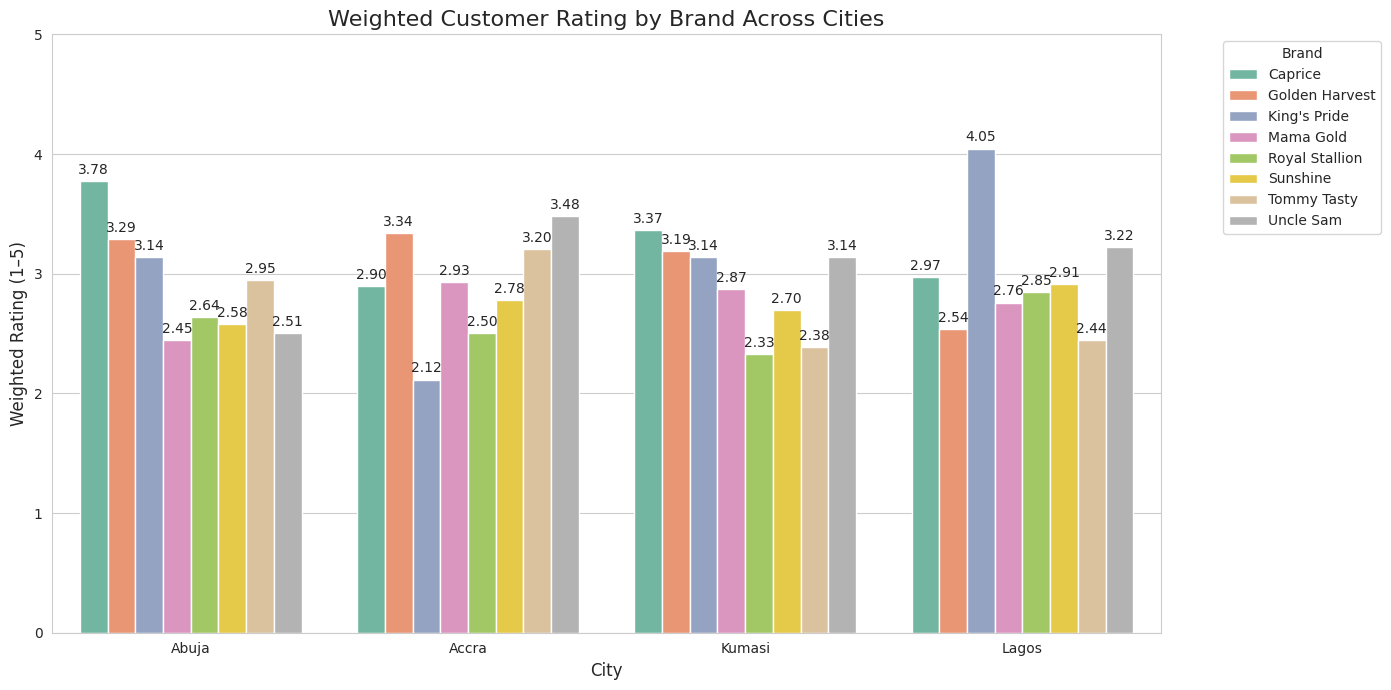

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Plot the column chart
column_chart = sns.barplot(
    data=weighted_city_rating,
    x='city',
    y='weighted_avg_rating',
    hue='brand_name',
    palette='Set2'
)

# Add value labels above each bar
for container in column_chart.containers:
    column_chart.bar_label(container, fmt='%.2f', fontsize=10, label_type='edge', padding=3)

# Chart formatting
plt.title('Weighted Customer Rating by Brand Across Cities', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Weighted Rating (1–5)', fontsize=12)
plt.ylim(0, 5)
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("brand_loyalty_column_chart.png", bbox_inches='tight', dpi=300)
plt.show()

#  Hypothesis Test

In [34]:
#  Hypothesis Test
from scipy.stats import pearsonr

corr, p_value = pearsonr(sales_data['review_count'], sales_data['units_sold'])

print(f"\nHypothesis Test (Reviews vs. Units Sold):")
print(f"- Correlation: {corr:.3f}")
print(f"- p-value: {p_value:.3f}")



Hypothesis Test (Reviews vs. Units Sold):
- Correlation: -0.036
- p-value: 0.401


# 4. PREDICTIVE MODELING.

# Model Training: Random Forest Regressor

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Identify non-numeric columns
non_numeric_cols = sales_data.select_dtypes(include=['object', 'category']).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)

# One-hot encode all non-numeric columns EXCEPT 'revenue'
categorical_cols = [col for col in non_numeric_cols if col not in ['month_sold', 'country', 'revenue']]
model_data = pd.get_dummies(sales_data, columns=categorical_cols)

# Drop unused or leakage-related columns
columns_to_drop = ['month_sold', 'country']
columns_to_drop = [col for col in columns_to_drop if col in model_data.columns]

# Define features (X) and target (y)
X = model_data.drop(columns=columns_to_drop + ['revenue'])
y = model_data['revenue']

# Ensure y is numeric
y = pd.to_numeric(y, errors='coerce')
X = X.apply(pd.to_numeric, errors='coerce')

# Drop any remaining rows with NaN values
X = X.dropna()
y = y[X.index]  # align target with cleaned X

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

Non-numeric columns: ['brand_name', 'grain_type', 'city', 'country', 'month_sold', 'price_tier']


RandomForestRegressor(random_state=42)

# Evaluate Model Performance

In [36]:
# Make predictions
predictions = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

# Print metrics
print("Model Performance Summary:")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: ₦{rmse:,.2f}")
print(f"MAE: ₦{mae:,.2f}")

Model Performance Summary:
R² Score: 0.995
RMSE: ₦408,021.34
MAE: ₦297,060.52


# Forecasting RizoStar Revenue in Top 3 Cities

In [37]:
# Set RizoStar's assumed price per bag (Naira)
rizo_price = 28000  # Adjust if needed

# Get top 3 cities by units sold
top_cities = sales_data.groupby('city')['units_sold'].sum().sort_values(ascending=False).head(3).index.tolist()

# Prepare list to store city-level revenue predictions
predictions_table = []

# Expected column order for prediction
expected_columns = X_train.columns

# Predict revenue for RizoStar in each of the top 3 cities
for city in top_cities:
    # Start with a template row
    test_case = X_train.iloc[0:1].copy()

    # Reset all feature values
    for col in test_case.columns:
        test_case[col] = False if test_case[col].dtype == bool else 0.0

    # Set one-hot city column
    city_col = f'city_{city}'
    if city_col in test_case.columns:
        test_case[city_col] = True

    # Set grain type to 'Basmati' (adjust if needed)
    if 'grain_type_Basmati' in test_case.columns:
        test_case['grain_type_Basmati'] = True
    elif 'grain_type_basmati' in test_case.columns:
        test_case['grain_type_basmati'] = True

    # Set other features
    test_case['price_per_bag'] = rizo_price
    test_case['units_sold'] = sales_data[sales_data['city'] == city]['units_sold'].median()
    test_case['customer_rating'] = 4.0
    test_case['review_count'] = sales_data['review_count'].median()

    # Ensure correct order of columns
    test_case = test_case[expected_columns]

    # Predict revenue
    predicted_revenue = model.predict(test_case)[0]
    predictions_table.append([city, round(predicted_revenue, 2)])

# Convert to DataFrame for display
import pandas as pd
forecast_df = pd.DataFrame(predictions_table, columns=['City', 'Forecasted Revenue (₦)'])
forecast_df.style.format({'Forecasted Revenue (₦)': '₦{:,.2f}'})


,City,Forecasted Revenue (₦)
0,Kumasi,"₦12,843,451.36"
1,Accra,"₦11,516,529.90"
2,Abuja,"₦13,388,763.78"


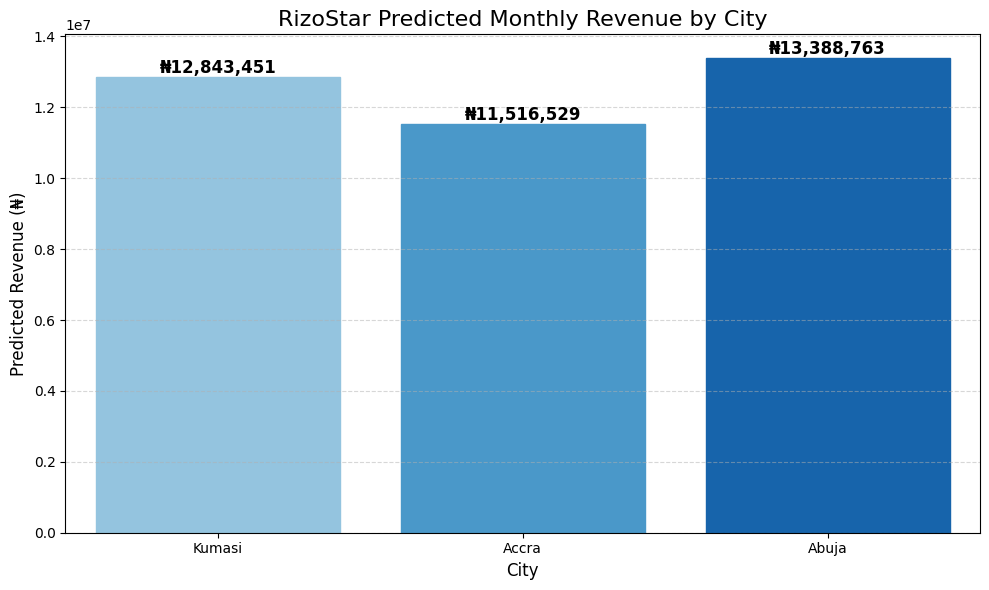

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# Assuming predictions_table is already defined
pred_df = pd.DataFrame(predictions_table, columns=['City', 'Predicted Monthly Revenue'])

# Convert revenue string (₦x,xxx.xx) back to float
pred_df['Revenue_Numeric'] = pred_df['Predicted Monthly Revenue'].replace('[₦,]', '', regex=True).astype(float)

plt.figure(figsize=(10, 6))

# Plot without palette to avoid warning
barplot = sns.barplot(data=pred_df, x='City', y='Revenue_Numeric')

# Create a blue sequential colormap and assign colors manually
num_bars = pred_df.shape[0]
colors = cm.Blues(np.linspace(0.4, 0.8, num_bars))  # lighter to darker blue

for patch, color in zip(barplot.patches, colors):
    patch.set_color(color)

# Add value labels on top of bars
for i, row in pred_df.iterrows():
    barplot.text(i, row['Revenue_Numeric'] + 10000, f"₦{int(row['Revenue_Numeric']):,}",
                 ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Formatting
plt.title("RizoStar Predicted Monthly Revenue by City", fontsize=16)
plt.ylabel("Predicted Revenue (₦)", fontsize=12)
plt.xlabel("City", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig("rizostar_predicted_revenue.png", bbox_inches='tight', transparent=True)
plt.show()

In [67]:
from google.colab import files

files.download('/content/brand_monopoly_heatmap.png')
files.download('/content/rizostar_predicted_revenue.png')
files.download('/content/jollof_wars_FULLY_CLEANED.csv')
files.download('/content/revenue_by_city.png')
files.download('/content/jollof_wars_rice_sales_messy.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>